In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [44]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [27]:
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
df = pd.read_csv('/content/cleaned_data.csv')

In [6]:
experience_df = pd.read_csv('/content/User_Experience.csv')

In [15]:
engagement_df = pd.read_csv('/content/aggregated_df.csv')

In [16]:
experience_df.head()

,CustomerID,AvgTCP,AvgRTT,AvgThroughput,Cluster
0,3.360100e+10,0.458987,0.213210,0.000881,1
1,3.360100e+10,0.458987,0.139050,0.001144,1
2,3.360100e+10,0.458987,0.508902,0.001144,1
3,3.360101e+10,0.000023,0.319815,0.004860,0
4,3.360101e+10,0.332602,0.264195,0.481166,0


In [17]:
engagement_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalDownload,TotalUpload,TotalTraffic
0,3.360100e+10,116720.0,1,8.426375e+08,36053108.0,8.786906e+08
1,3.360100e+10,181230.0,1,1.207552e+08,36104459.0,1.568596e+08
2,3.360100e+10,134969.0,1,5.566597e+08,39306820.0,5.959665e+08
3,3.360101e+10,49878.0,1,4.019932e+08,20327526.0,4.223207e+08
4,3.360101e+10,37104.0,2,1.363130e+09,94280527.0,1.457411e+09


In [19]:
merged_df = engagement_df.merge(experience_df, left_on='MSISDN/Number', right_on="CustomerID", how='inner')
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalDownload,TotalUpload,TotalTraffic,CustomerID,AvgTCP,AvgRTT,AvgThroughput,Cluster
0,3.360100e+10,116720.0,1,8.426375e+08,36053108.0,8.786906e+08,3.360100e+10,0.458987,0.213210,0.000881,1
1,3.360100e+10,181230.0,1,1.207552e+08,36104459.0,1.568596e+08,3.360100e+10,0.458987,0.139050,0.001144,1
2,3.360100e+10,134969.0,1,5.566597e+08,39306820.0,5.959665e+08,3.360100e+10,0.458987,0.508902,0.001144,1
3,3.360101e+10,49878.0,1,4.019932e+08,20327526.0,4.223207e+08,3.360101e+10,0.000023,0.319815,0.004860,0
4,3.360101e+10,37104.0,2,1.363130e+09,94280527.0,1.457411e+09,3.360101e+10,0.332602,0.264195,0.481166,0


In [20]:
experience_columns = ["AvgTCP","AvgRTT","AvgThroughput"]
engagement_columns = ["SessionDuration","SessionFrequency","TotalTraffic"]

**Assigning scores**

In [21]:
k = 3
X_eng = merged_df[engagement_columns]
X_exp = merged_df[experience_columns]

**Assign engagement score**

In [24]:
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_eng)
merged_df['cluster'] = cluster_labels

**Get less engaged cluster**

In [25]:
merged_df['AVG'] = (merged_df['SessionDuration'] + merged_df['SessionFrequency'] + merged_df['TotalTraffic']) / 3
grouped = merged_df.groupby('cluster', as_index=False)['AVG'].mean()
less_engaged_cluster = grouped.loc[grouped['AVG'].idxmin(), 'cluster']
less_engaged_cluster

1

In [28]:
less_engaged_cluster_center = kmeans.cluster_centers_[less_engaged_cluster]

distances = euclidean_distances(X_eng, [less_engaged_cluster_center]).flatten()
merged_df['EngagementScore'] =  distances
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalDownload,TotalUpload,TotalTraffic,CustomerID,AvgTCP,AvgRTT,AvgThroughput,Cluster,cluster,AVG,EngagementScore
0,3.360100e+10,116720.0,1,8.426375e+08,36053108.0,8.786906e+08,3.360100e+10,0.458987,0.213210,0.000881,1,0,2.929358e+08,5.442613e+08
1,3.360100e+10,181230.0,1,1.207552e+08,36104459.0,1.568596e+08,3.360100e+10,0.458987,0.139050,0.001144,1,1,5.234696e+07,1.775696e+08
2,3.360100e+10,134969.0,1,5.566597e+08,39306820.0,5.959665e+08,3.360100e+10,0.458987,0.508902,0.001144,1,0,1.987005e+08,2.615373e+08
3,3.360101e+10,49878.0,1,4.019932e+08,20327526.0,4.223207e+08,3.360101e+10,0.000023,0.319815,0.004860,0,1,1.407902e+08,8.789149e+07
4,3.360101e+10,37104.0,2,1.363130e+09,94280527.0,1.457411e+09,3.360101e+10,0.332602,0.264195,0.481166,0,2,4.858160e+08,1.122982e+09


**Get worst experience cluster**

In [29]:
merged_df['AVG'] = (merged_df['AvgTCP'] + merged_df['AvgRTT'] + merged_df['AvgThroughput']) / 3
grouped = merged_df.groupby('cluster', as_index=False)['AVG'].mean()
worst_experience_cluster = grouped.loc[grouped['AVG'].idxmin(), 'cluster']
worst_experience_cluster

1

**Assign Experience score**

In [31]:
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_exp)

worst_experience_cluster_cluster_center = kmeans.cluster_centers_[worst_experience_cluster]

distances = euclidean_distances(X_eng, [worst_experience_cluster_cluster_center]).flatten()
merged_df['ExperienceScore'] =  distances
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalDownload,TotalUpload,TotalTraffic,CustomerID,AvgTCP,AvgRTT,AvgThroughput,Cluster,cluster,AVG,EngagementScore,ExperienceScore
0,3.360100e+10,116720.0,1,8.426375e+08,36053108.0,8.786906e+08,3.360100e+10,0.458987,0.213210,0.000881,1,0,0.224359,5.442613e+08,8.786906e+08
1,3.360100e+10,181230.0,1,1.207552e+08,36104459.0,1.568596e+08,3.360100e+10,0.458987,0.139050,0.001144,1,1,0.199727,1.775696e+08,1.568597e+08
2,3.360100e+10,134969.0,1,5.566597e+08,39306820.0,5.959665e+08,3.360100e+10,0.458987,0.508902,0.001144,1,0,0.323011,2.615373e+08,5.959665e+08
3,3.360101e+10,49878.0,1,4.019932e+08,20327526.0,4.223207e+08,3.360101e+10,0.000023,0.319815,0.004860,0,1,0.108233,8.789149e+07,4.223207e+08
4,3.360101e+10,37104.0,2,1.363130e+09,94280527.0,1.457411e+09,3.360101e+10,0.332602,0.264195,0.481166,0,2,0.359321,1.122982e+09,1.457411e+09


**Satisfaction Score**

In [32]:
merged_df['SatisfactionScore'] = (merged_df['EngagementScore'] + merged_df['ExperienceScore']) / 2
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalDownload,TotalUpload,TotalTraffic,CustomerID,AvgTCP,AvgRTT,AvgThroughput,Cluster,cluster,AVG,EngagementScore,ExperienceScore,SatisfactionScore
0,3.360100e+10,116720.0,1,8.426375e+08,36053108.0,8.786906e+08,3.360100e+10,0.458987,0.213210,0.000881,1,0,0.224359,5.442613e+08,8.786906e+08,7.114760e+08
1,3.360100e+10,181230.0,1,1.207552e+08,36104459.0,1.568596e+08,3.360100e+10,0.458987,0.139050,0.001144,1,1,0.199727,1.775696e+08,1.568597e+08,1.672147e+08
2,3.360100e+10,134969.0,1,5.566597e+08,39306820.0,5.959665e+08,3.360100e+10,0.458987,0.508902,0.001144,1,0,0.323011,2.615373e+08,5.959665e+08,4.287519e+08
3,3.360101e+10,49878.0,1,4.019932e+08,20327526.0,4.223207e+08,3.360101e+10,0.000023,0.319815,0.004860,0,1,0.108233,8.789149e+07,4.223207e+08,2.551061e+08
4,3.360101e+10,37104.0,2,1.363130e+09,94280527.0,1.457411e+09,3.360101e+10,0.332602,0.264195,0.481166,0,2,0.359321,1.122982e+09,1.457411e+09,1.290196e+09


**Top satisfied users**

In [33]:
sorted_df = merged_df[['MSISDN/Number', 'SatisfactionScore']].sort_values(by='SatisfactionScore', ascending=False)
top_10 = sorted_df.head(10)
top_10

,MSISDN/Number,SatisfactionScore
13994,3.362708e+10,5.587516e+09
57160,3.366469e+10,5.514793e+09
30225,3.365826e+10,5.507993e+09
58859,3.366514e+10,5.465767e+09
106137,3.378632e+10,5.455017e+09
65118,3.366716e+10,5.451179e+09
9090,3.361923e+10,5.345192e+09
15664,3.363004e+10,5.326927e+09
1279,3.360452e+10,5.320641e+09
60087,3.366546e+10,5.221416e+09


In [34]:
merged_df['SatisfactionScore'].describe()

,SatisfactionScore
count,1.068560e+05
mean,5.525626e+08
std,4.569542e+08
min,1.672146e+08
25%,1.913353e+08
50%,4.507085e+08
75%,6.901445e+08
max,5.587516e+09


In [42]:
bins

array([0.     , 0.35355, 0.7071 , 1.06065])

**Linear Regression**

In [45]:
features = engagement_columns + experience_columns
X = merged_df[features]
y = merged_df.SatisfactionScore

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred  = model.predict(X_test)

**KMeans clustering**

In [46]:
selected_columns = ["EngagementScore", "SatisfactionScore"]
X = merged_df[selected_columns]
k = 2

kmeans = KMeans(n_clusters=k, random_state=0, n_init=15)
kmeans.fit(X)

merged_df['cluster'] = kmeans.labels_

**Clusters plot**

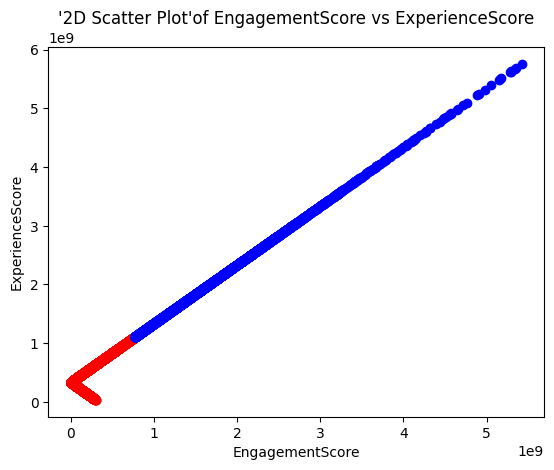

In [47]:
cluster_colors = {0: 'red', 1: 'blue'}
for cluster_label, color in cluster_colors.items():
    cluster_df = merged_df[merged_df["cluster"] == cluster_label]
    plt.scatter(cluster_df["EngagementScore"], cluster_df["ExperienceScore"], c=color)


plt.xlabel("EngagementScore")
plt.ylabel("ExperienceScore")
plt.title("'2D Scatter Plot'of EngagementScore vs ExperienceScore")

plt.show()

**Average Satisfaction per cluster**

In [48]:
avg_satisfaction = merged_df.groupby('cluster', as_index=False)['SatisfactionScore'].mean()
avg_satisfaction = avg_satisfaction.rename(columns={'SatisfactionScore': 'Average Satisfaction'})
print(avg_satisfaction)

   cluster  Average Satisfaction
0        0          4.096251e+08
1        1          1.458789e+09


**Average experience Score per cluster**

In [49]:
avg_experience = merged_df.groupby('cluster', as_index=False)['ExperienceScore'].mean()
avg_experience = avg_experience.rename(columns={'ExperienceScore': 'Average Experience'})
print(avg_experience)

   cluster  Average Experience
0        0        5.425892e+08
1        1        1.626003e+09


In [50]:
df = pd.DataFrame({
    "UserID": merged_df["CustomerID"],
    "SatisfactionScore": merged_df["SatisfactionScore"],
    "ExperienceScore": merged_df["ExperienceScore"],
    "EngagementScore": merged_df["EngagementScore"]
})

df.to_csv("satisfaction_score.csv", index=False)

**Inference:**
**Cluster Comparison:**

Cluster 1 has significantly higher average scores for both satisfaction and experience compared to Cluster 0. This suggests that users in Cluster 1 generally report higher levels of satisfaction and experience compared to those in Cluster 0.

**Insights on User Segments:**

Users in Cluster 1 might be more engaged or have better experiences with your product or service, leading to higher average satisfaction and experience scores.
Cluster 0 could represent a segment that is less satisfied or experiences more issues compared to Cluster 1. This could indicate areas for improvement in your product or service for this segment.